## Voice Detection

In [26]:
import os
import numpy as np
import librosa
import tsfel
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import joblib

In [19]:
# === Folder data ===
buka_path = "data/voice/buka-voice"
tutup_path = "data/voice/tutup-voice"

# === Load konfigurasi fitur TSFEL ===
cfg = tsfel.get_features_by_domain()  # semua domain: temporal, spectral, statistical

# === Fungsi ekstraksi fitur dengan TSFEL ===
def extract_features_tsfel(file_path):
    # Load audio
    y, sr = librosa.load(file_path, sr=None)
    
    # Pastikan durasi tidak terlalu pendek
    if len(y) < sr:
        y = np.pad(y, (0, sr - len(y)))
    
    # Ekstraksi fitur dengan TSFEL
    features = tsfel.time_series_features_extractor(cfg, y, fs=sr, verbose=0)
    
    # Ambil rata-rata dari setiap fitur agar menjadi satu baris data
    features_mean = features.mean().to_frame().T
    return features_mean

# === Persiapan data ===
X, y = [], []

print("🔍 Mengekstrak fitur dari folder 'buka-voice' ...")
for file in os.listdir(buka_path):
    if file.endswith(".mp3"):
        file_path = os.path.join(buka_path, file)
        features = extract_features_tsfel(file_path)
        X.append(features)
        y.append(0)

print("🔍 Mengekstrak fitur dari folder 'tutup-voice' ...")
for file in os.listdir(tutup_path):
    if file.endswith(".mp3"):
        file_path = os.path.join(tutup_path, file)
        features = extract_features_tsfel(file_path)
        X.append(features)
        y.append(1)

🔍 Mengekstrak fitur dari folder 'buka-voice' ...
🔍 Mengekstrak fitur dari folder 'tutup-voice' ...


In [ ]:
X = np.array(X)
y = np.array(y)

# === Split data untuk training dan testing ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Normalisasi ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

[[4.05262665e+02 7.44337818e-02 1.10000000e+01 ... 1.68264629e-03
  4.44990018e-04 7.75000000e+03]
 [1.08869456e+03 9.69186403e-02 1.30000000e+01 ... 2.29991717e-03
  5.54476208e-04 7.31200000e+03]
 [1.94248253e+02 4.50505102e-02 1.60000000e+01 ... 1.06309256e-03
  3.25874603e-04 6.35600000e+03]
 ...
 [1.92249170e+02 2.82727582e-02 2.10000000e+01 ... 4.27927661e-04
  1.44763860e-04 7.48800000e+03]
 [2.33947466e+03 1.21908520e-01 2.10000000e+01 ... 2.20849142e-03
  6.82708095e-04 7.34200000e+03]
 [5.19980689e+02 5.22316571e-02 2.00000000e+01 ... 4.95847142e-04
  1.31211480e-04 6.02800000e+03]]


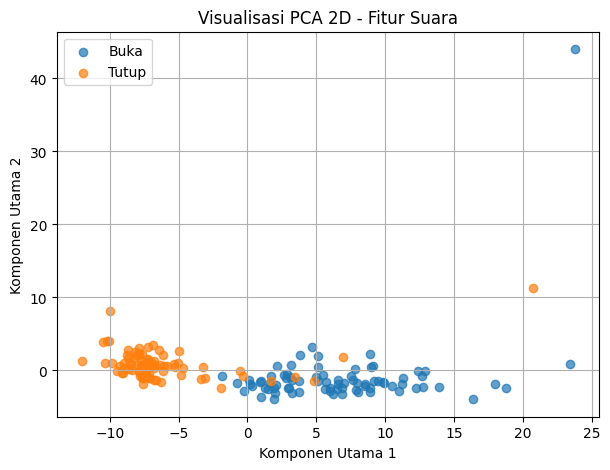

In [21]:
# ==================================================
# 🔹 PCA 2D
# ==================================================
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_train_scaled)

plt.figure(figsize=(7, 5))
plt.scatter(
    X_pca_2d[y_train == 0, 0],
    X_pca_2d[y_train == 0, 1],
    label="Buka",
    alpha=0.7
)
plt.scatter(
    X_pca_2d[y_train == 1, 0],
    X_pca_2d[y_train == 1, 1],
    label="Tutup",
    alpha=0.7
)
plt.title("Visualisasi PCA 2D - Fitur Suara")
plt.xlabel("Komponen Utama 1")
plt.ylabel("Komponen Utama 2")
plt.legend()
plt.grid(True)
plt.show()

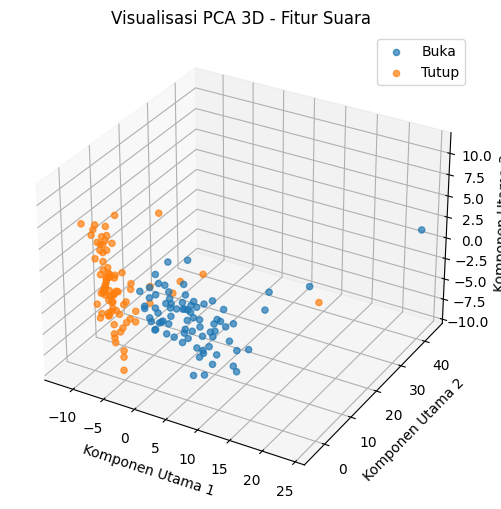

In [22]:
# ==================================================
# 🔹 PCA 3D
# ==================================================
from mpl_toolkits.mplot3d import Axes3D

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_train_scaled)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    X_pca_3d[y_train == 0, 0],
    X_pca_3d[y_train == 0, 1],
    X_pca_3d[y_train == 0, 2],
    label="Buka",
    alpha=0.7
)
ax.scatter(
    X_pca_3d[y_train == 1, 0],
    X_pca_3d[y_train == 1, 1],
    X_pca_3d[y_train == 1, 2],
    label="Tutup",
    alpha=0.7
)
ax.set_title("Visualisasi PCA 3D - Fitur Suara")
ax.set_xlabel("Komponen Utama 1")
ax.set_ylabel("Komponen Utama 2")
ax.set_zlabel("Komponen Utama 3")
ax.legend()
plt.show()

In [23]:
# === Model KNN ===
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)

# === Evaluasi ===
y_pred = knn.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# === Simpan model & scaler jika ingin digunakan ulang ===
joblib.dump(knn, "model_knn_voice.pkl")
joblib.dump(scaler, "scaler.pkl")

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        19

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41



['scaler.pkl']

In [16]:
import sounddevice as sd
import wavio
import joblib
import librosa
import numpy as np

duration = 3  # durasi rekam dalam detik
samplerate = 44100  # sample rate umum

print("🎙️ Mulai merekam...")
recording = sd.rec(int(duration * samplerate), samplerate=samplerate, channels=1, dtype='float32')
sd.wait()
print("✅ Rekaman selesai!")

# Simpan hasil rekaman
file_path = "recorded.wav"
wavio.write(file_path, recording, samplerate, sampwidth=2)

# Load model dan scaler
model = joblib.load("model_knn_voice.pkl")
scaler = joblib.load("scaler.pkl")

# Ekstraksi fitur dan prediksi
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return np.mean(mfcc.T, axis=0)

features = extract_features(file_path).reshape(1, -1)
features = scaler.transform(features)

pred = model.predict(features)
print("Prediksi:", "BUKA" if pred[0] == 0 else "TUTUP")


🎙️ Mulai merekam...
✅ Rekaman selesai!
Prediksi: TUTUP


## NEW

In [33]:
import os
import numpy as np
import pandas as pd
import librosa
import tsfel

# === Folder data ===
buka_path = "data/voice/buka-voice"
tutup_path = "data/voice/tutup-voice"

# === Konfigurasi fitur TSFEL ===
# Ambil semua fitur dari 3 domain: statistical, temporal, spectral
cfg = tsfel.get_features_by_domain()

# === Fungsi ekstraksi fitur dari file suara ===
def extract_features_tsfel(file_path):
    # Load audio
    y, sr = librosa.load(file_path, sr=None)

    # Pastikan sinyal minimal berdurasi 1 detik
    if len(y) < sr:
        y = np.pad(y, (0, sr - len(y)))

    # Ekstraksi fitur Statistical, Temporal, dan Spectral
    features = tsfel.time_series_features_extractor(cfg, y, fs=sr, verbose=0)

    # Ambil rata-rata setiap fitur agar jadi satu baris data
    features_mean = features.mean().to_frame().T
    return features_mean

# === Persiapan data ===
X_list, y_list = [], []

# Proses folder 'buka'
for file in os.listdir(buka_path):
    if file.endswith(".mp3"):
        file_path = os.path.join(buka_path, file)
        print(f"Ekstraksi fitur (BUKA): {file_path}")
        feats = extract_features_tsfel(file_path)
        X_list.append(feats)
        y_list.append(0)  # Label 0 untuk 'buka'

# Proses folder 'tutup'
for file in os.listdir(tutup_path):
    if file.endswith(".mp3"):
        file_path = os.path.join(tutup_path, file)
        print(f"Ekstraksi fitur (TUTUP): {file_path}")
        feats = extract_features_tsfel(file_path)
        X_list.append(feats)
        y_list.append(1)  # Label 1 untuk 'tutup'

# === Gabungkan semua hasil ekstraksi ===
X = pd.concat(X_list, ignore_index=True)
y = np.array(y_list)

# Tambahkan label ke dataframe
X['label'] = y

# === Simpan ke file CSV ===
output_path = "data/features_tsfel_all.csv"
X.to_csv(output_path, index=False)

print("\n✅ Ekstraksi fitur selesai!")
print(f"Jumlah sample  : {len(X)}")
print(f"Jumlah fitur   : {X.shape[1] - 1} (tanpa label)")
print(f"File hasil     : {output_path}")


Ekstraksi fitur (BUKA): data/voice/buka-voice\Record (online-voice-recorder.com) (1).mp3
Ekstraksi fitur (BUKA): data/voice/buka-voice\Record (online-voice-recorder.com) (10).mp3
Ekstraksi fitur (BUKA): data/voice/buka-voice\Record (online-voice-recorder.com) (100).mp3
Ekstraksi fitur (BUKA): data/voice/buka-voice\Record (online-voice-recorder.com) (11).mp3
Ekstraksi fitur (BUKA): data/voice/buka-voice\Record (online-voice-recorder.com) (12).mp3
Ekstraksi fitur (BUKA): data/voice/buka-voice\Record (online-voice-recorder.com) (13).mp3
Ekstraksi fitur (BUKA): data/voice/buka-voice\Record (online-voice-recorder.com) (14).mp3
Ekstraksi fitur (BUKA): data/voice/buka-voice\Record (online-voice-recorder.com) (15).mp3
Ekstraksi fitur (BUKA): data/voice/buka-voice\Record (online-voice-recorder.com) (16).mp3
Ekstraksi fitur (BUKA): data/voice/buka-voice\Record (online-voice-recorder.com) (17).mp3
Ekstraksi fitur (BUKA): data/voice/buka-voice\Record (online-voice-recorder.com) (18).mp3
Ekstraksi 

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import mutual_info_classif
import joblib
import seaborn as sns

In [42]:
# === 1️⃣ Baca file CSV hasil ekstraksi fitur ===
data_path = "data/features_tsfel_all.csv"  # ganti sesuai lokasi file kamu
df = pd.read_csv(data_path)

print("✅ Data berhasil dibaca!")
print("Jumlah sample:", len(df))
print("Jumlah kolom :", len(df.columns))

✅ Data berhasil dibaca!
Jumlah sample: 203
Jumlah kolom : 157


In [36]:
# === 2️⃣ Pisahkan fitur dan label ===
X = df.drop(columns=["label"])
y = df["label"].values

# === 3️⃣ Tangani missing values ===
X = X.fillna(X.median())

In [37]:
# === 4️⃣ Split data (80% train, 20% test) ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === 5️⃣ Normalisasi (StandardScaler) ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

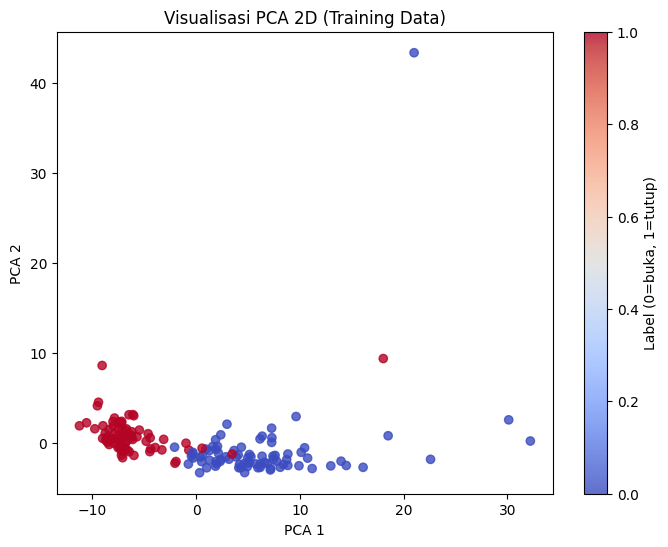

In [38]:
# === 6️⃣ PCA 2D ===
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_train_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca_2d[:,0], X_pca_2d[:,1], c=y_train, cmap='coolwarm', alpha=0.8)
plt.title("Visualisasi PCA 2D (Training Data)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label='Label (0=buka, 1=tutup)')
plt.show()

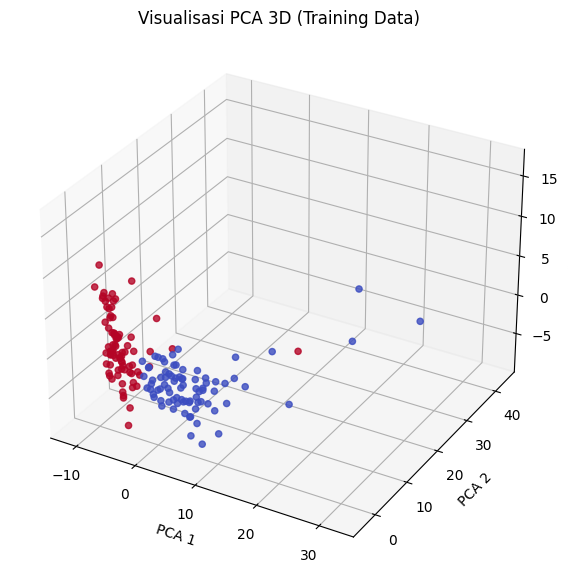

In [39]:
# === 7️⃣ PCA 3D ===
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_train_scaled)

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca_3d[:,0], X_pca_3d[:,1], X_pca_3d[:,2], c=y_train, cmap='coolwarm', alpha=0.8)
ax.set_title("Visualisasi PCA 3D (Training Data)")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
plt.show()

In [40]:
# === 8️⃣ Modeling (KNN) ===
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)

# === 9️⃣ Evaluasi ===
y_pred = knn.predict(X_test_scaled)
print("\n=== HASIL EVALUASI ===")
print("Accuracy :", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["Buka", "Tutup"]))


=== HASIL EVALUASI ===
Accuracy : 1.0
              precision    recall  f1-score   support

        Buka       1.00      1.00      1.00        20
       Tutup       1.00      1.00      1.00        21

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41



In [ ]:
# === 🔟 Simpan model & scaler ===
joblib.dump(knn, "model_knn_voice_tsfel.pkl")
joblib.dump(scaler, "scaler_tsfel.pkl")

print("\n✅ Model dan scaler berhasil disimpan!")

In [56]:
# === 5️⃣ Hitung Information Gain (mutual information) ===
info_gain = mutual_info_classif(X, y, random_state=42)

# === 6️⃣ Buat DataFrame ranking ===
ig_df = pd.DataFrame({
    "feature": X.columns,
    "information_gain": info_gain
}).sort_values(by="information_gain", ascending=False).reset_index(drop=True)



🔥 156 Fitur dengan Information Gain Tertinggi:
                                   feature  information_gain
0                        0_Autocorrelation          0.695604
1                        0_Power bandwidth          0.674564
2                       0_Spectral entropy          0.659403
3              0_Wavelet variance_2000.0Hz          0.590360
4    0_Wavelet standard deviation_2000.0Hz          0.588336
..                                     ...               ...
151                               0_MFCC_6          0.000000
152                               0_MFCC_7          0.000000
153                                0_Slope          0.000000
154                    0_Spectral skewness          0.000000
155                   0_Zero crossing rate          0.000000

[156 rows x 2 columns]


C:\Users\risqi\AppData\Local\Temp\ipykernel_13300\56722980.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


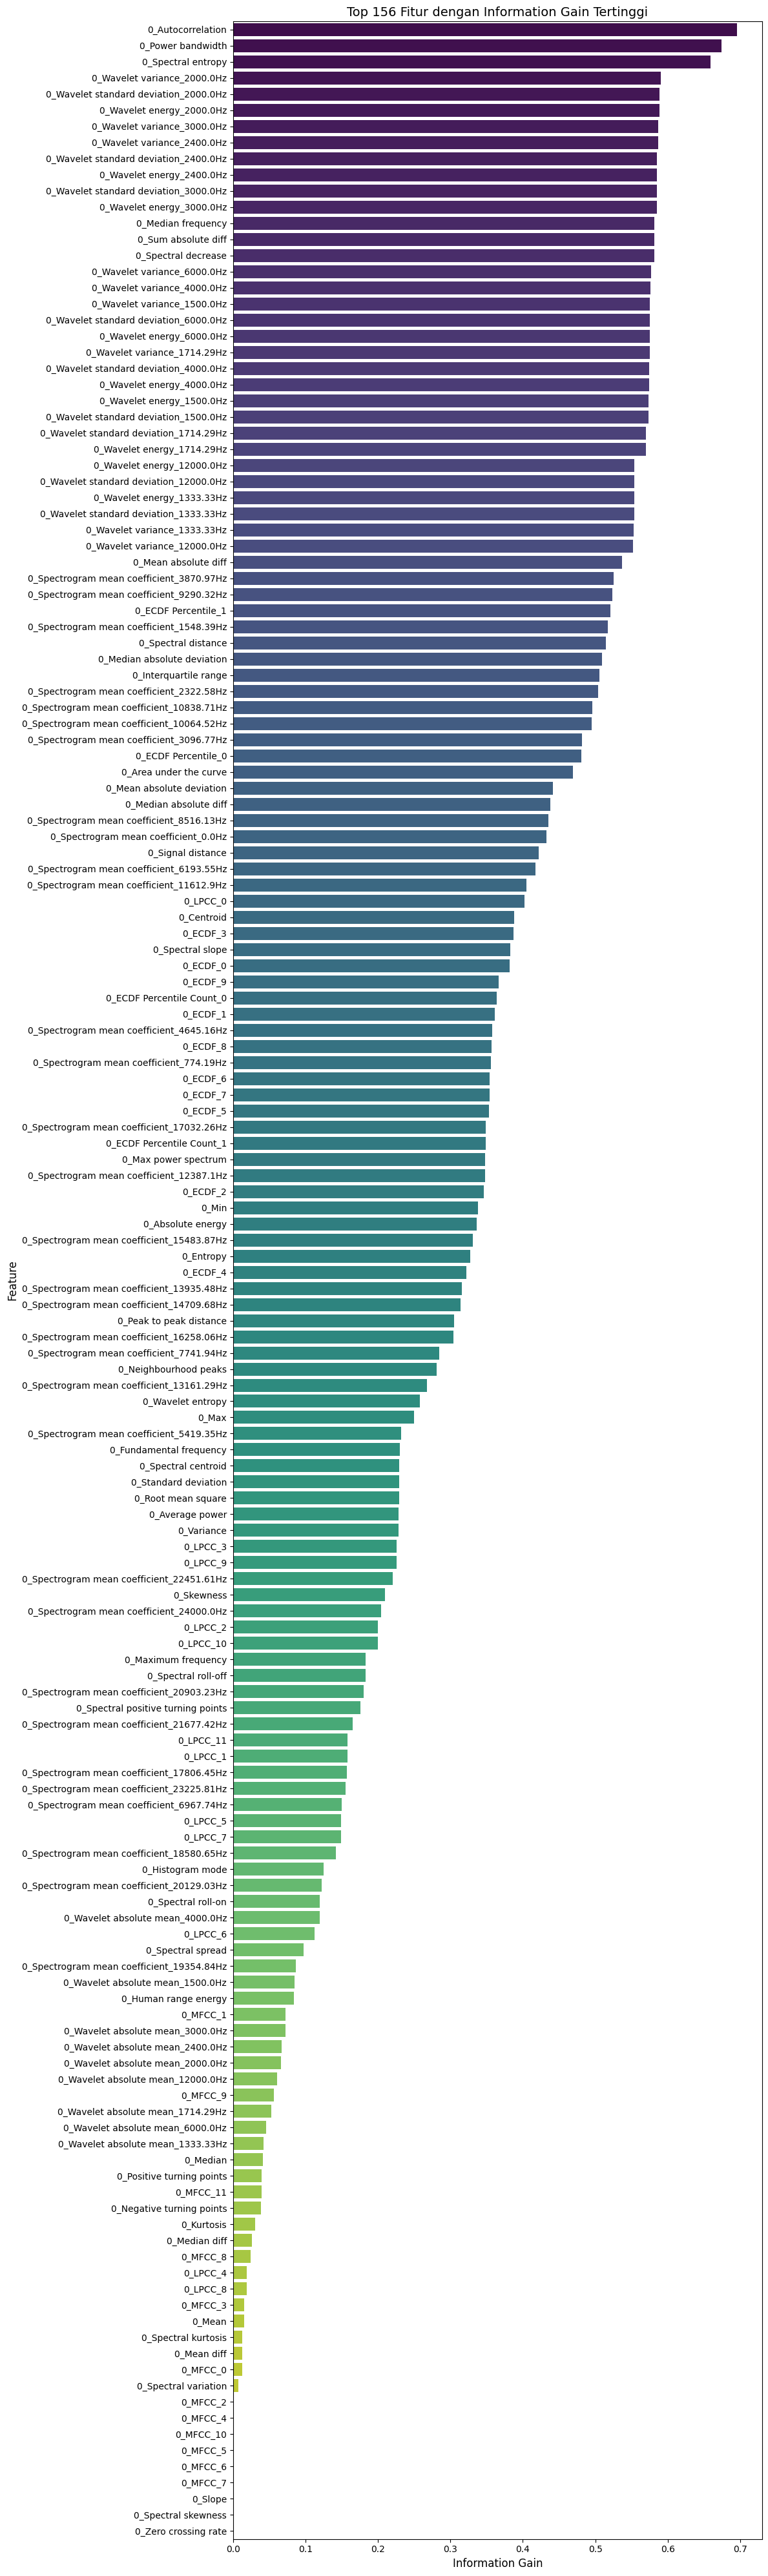

In [58]:
# === 7️⃣ Tampilkan 15 fitur dengan Information Gain tertinggi ===
top_n = 156
print(f"\n🔥 {top_n} Fitur dengan Information Gain Tertinggi:")
print(ig_df.head(top_n))

# === 8️⃣ Visualisasi top 15 fitur ===
plt.figure(figsize=(12, 40))  # perbesar tinggi figure
sns.barplot(
    x="information_gain",
    y="feature",
    data=ig_df,
    palette="viridis"
)
plt.title("Top 156 Fitur dengan Information Gain Tertinggi", fontsize=14)
plt.xlabel("Information Gain", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

In [59]:
# === 1️⃣ Filter hanya fitur dengan information gain > 0 ===
ig_filtered = ig_df[ig_df["information_gain"] > 0].reset_index(drop=True)

print(f"Jumlah fitur awal: {len(ig_df)}")
print(f"Jumlah fitur setelah filtering: {len(ig_filtered)}")

# === 2️⃣ Ambil nama fitur penting saja ===
selected_features = ig_filtered["feature"].tolist()

# === 3️⃣ Filter dataset aslinya (X) ===
X_selected = X[selected_features]

print("✅ Fitur dengan nilai Information Gain > 0 berhasil dipilih!")
print(X_selected.shape)


Jumlah fitur awal: 156
Jumlah fitur setelah filtering: 147
✅ Fitur dengan nilai Information Gain > 0 berhasil dipilih!
(203, 147)


C:\Users\risqi\AppData\Local\Temp\ipykernel_13300\1172477502.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


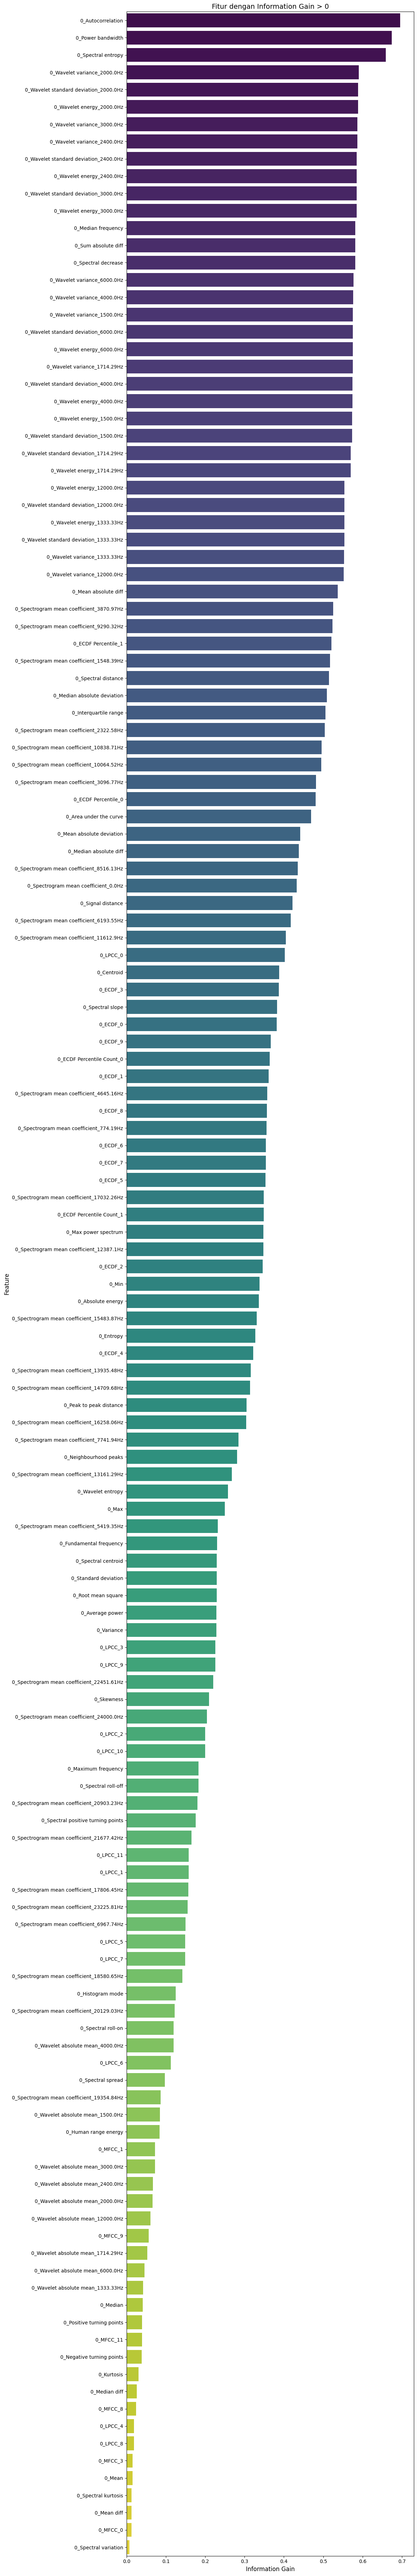

In [60]:
plt.figure(figsize=(12, len(ig_filtered) / 2))  # tinggi disesuaikan
sns.barplot(
    x="information_gain",
    y="feature",
    data=ig_filtered,
    palette="viridis"
)
plt.title("Fitur dengan Information Gain > 0", fontsize=14)
plt.xlabel("Information Gain", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()


In [62]:
# === 1️⃣ Split data (80% train, 20% test) ===
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

# === 2️⃣ Normalisasi fitur ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [64]:
# === 3️⃣ Inisialisasi & training model KNN ===
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)

# === 4️⃣ Prediksi ===
y_pred = knn.predict(X_test_scaled)

# === 5️⃣ Evaluasi ===
print("📊 Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Buka", "Tutup"]))

📊 Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

        Buka       1.00      1.00      1.00        20
       Tutup       1.00      1.00      1.00        21

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41



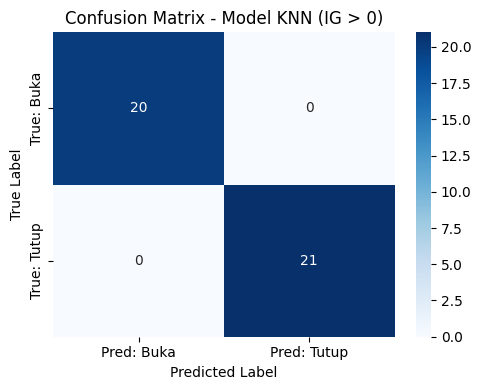

In [67]:
# === 6️⃣ Visualisasi confusion matrix ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred: Buka", "Pred: Tutup"],
            yticklabels=["True: Buka", "True: Tutup"])
plt.title("Confusion Matrix - Model KNN (IG > 0)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [ ]:
# === 9️⃣ Simpan hasil ranking ke CSV ===
ig_df.to_csv("data/feature_information_gain_ranking.csv", index=False)
print("\n✅ Hasil ranking disimpan ke 'data/feature_information_gain_ranking.csv'")

## Hapus 50 fitur terbawah

In [68]:
# === Urutkan kembali berdasarkan Information Gain (descending) ===
ig_sorted = ig_df.sort_values(by="information_gain", ascending=False).reset_index(drop=True)

# === Hapus 50 fitur terbawah ===
ig_top = ig_sorted.iloc[:-50, :]  # ambil semua kecuali 50 terbawah
print(f"Jumlah fitur awal: {len(ig_sorted)}")
print(f"Jumlah fitur setelah menghapus 50 terbawah: {len(ig_top)}")

# === Ambil nama fitur terpilih ===
selected_top_features = ig_top["feature"].tolist()

# === Filter dataset ===
X_top = X[selected_top_features]
print("✅ Dataset berhasil difilter dengan fitur terbaik saja:", X_top.shape)


Jumlah fitur awal: 156
Jumlah fitur setelah menghapus 50 terbawah: 106
✅ Dataset berhasil difilter dengan fitur terbaik saja: (203, 106)


📊 Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

        Buka       1.00      1.00      1.00        20
       Tutup       1.00      1.00      1.00        21

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41



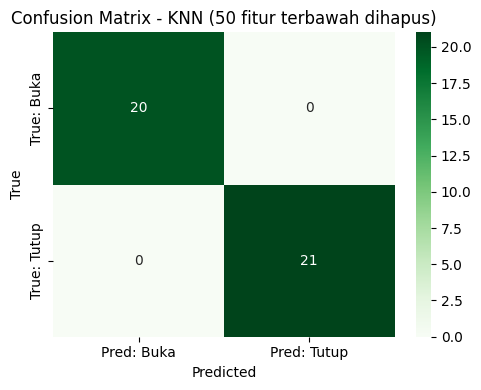

In [69]:
# === Split data ===
X_train, X_test, y_train, y_test = train_test_split(
    X_top, y, test_size=0.2, random_state=42, stratify=y
)

# === Normalisasi ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Model KNN ===
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)

# === Prediksi ===
y_pred = knn.predict(X_test_scaled)

# === Evaluasi ===
print("📊 Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Buka", "Tutup"]))

# === Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Pred: Buka", "Pred: Tutup"],
            yticklabels=["True: Buka", "True: Tutup"])
plt.title("Confusion Matrix - KNN (50 fitur terbawah dihapus)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [70]:
print(f"Jumlah fitur sebelum seleksi: {X.shape[1]}")
print(f"Jumlah fitur setelah hapus 50 terbawah: {X_top.shape[1]}")


Jumlah fitur sebelum seleksi: 156
Jumlah fitur setelah hapus 50 terbawah: 106


## Hapus 75 fitur terbawah

In [75]:
# === Urutkan fitur berdasarkan Information Gain (dari tertinggi ke terendah) ===
ig_sorted = ig_df.sort_values(by="information_gain", ascending=False).reset_index(drop=True)

# === Hapus 75 fitur terbawah ===
ig_top = ig_sorted.iloc[:-75, :]  # ambil semua kecuali 75 terbawah
print(f"Jumlah fitur awal: {len(ig_sorted)}")
print(f"Jumlah fitur setelah menghapus 75 terbawah: {len(ig_top)}")

# === Ambil nama fitur terbaik ===
selected_top_features = ig_top["feature"].tolist()

# === Filter dataset sesuai fitur terpilih ===
X_top = X[selected_top_features]
print("✅ Dataset berhasil difilter dengan fitur terbaik:", X_top.shape)


Jumlah fitur awal: 156
Jumlah fitur setelah menghapus 75 terbawah: 81
✅ Dataset berhasil difilter dengan fitur terbaik: (203, 81)


📊 Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

        Buka       1.00      1.00      1.00        20
       Tutup       1.00      1.00      1.00        21

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41



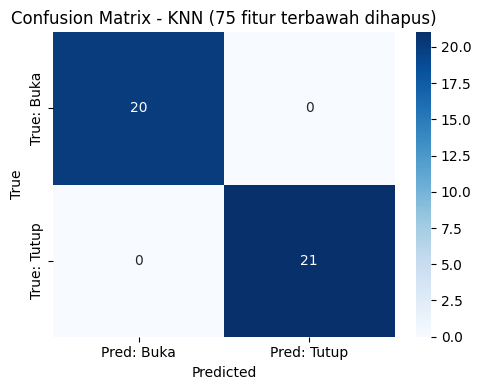

In [76]:
# === Split data menjadi train & test ===
X_train, X_test, y_train, y_test = train_test_split(
    X_top, y, test_size=0.2, random_state=42, stratify=y
)

# === Normalisasi fitur ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Latih model KNN ===
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)

# === Prediksi ===
y_pred = knn.predict(X_test_scaled)

# === Evaluasi model ===
print("📊 Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Buka", "Tutup"]))

# === Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred: Buka", "Pred: Tutup"],
            yticklabels=["True: Buka", "True: Tutup"])
plt.title("Confusion Matrix - KNN (75 fitur terbawah dihapus)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

## Hapus 100 fitur terbawah

In [71]:
# === Urutkan kembali berdasarkan Information Gain (descending) ===
ig_sorted = ig_df.sort_values(by="information_gain", ascending=False).reset_index(drop=True)

# === Hapus 100 fitur terbawah ===
ig_top = ig_sorted.iloc[:-100, :]  # ambil semua kecuali 100 terbawah
print(f"Jumlah fitur awal: {len(ig_sorted)}")
print(f"Jumlah fitur setelah menghapus 100 terbawah: {len(ig_top)}")

# === Ambil nama fitur terpilih ===
selected_top_features = ig_top["feature"].tolist()

# === Filter dataset ===
X_top = X[selected_top_features]
print("✅ Dataset berhasil difilter dengan fitur terbaik saja:", X_top.shape)


Jumlah fitur awal: 156
Jumlah fitur setelah menghapus 100 terbawah: 56
✅ Dataset berhasil difilter dengan fitur terbaik saja: (203, 56)


📊 Accuracy: 0.9512195121951219

Classification Report:
              precision    recall  f1-score   support

        Buka       0.91      1.00      0.95        20
       Tutup       1.00      0.90      0.95        21

    accuracy                           0.95        41
   macro avg       0.95      0.95      0.95        41
weighted avg       0.96      0.95      0.95        41



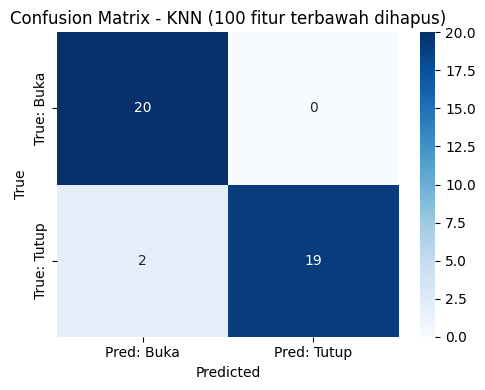

In [74]:
# === Split data ===
X_train, X_test, y_train, y_test = train_test_split(
    X_top, y, test_size=0.2, random_state=42, stratify=y
)

# === Normalisasi ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Model KNN ===
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)

# === Prediksi ===
y_pred = knn.predict(X_test_scaled)

# === Evaluasi ===
print("📊 Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Buka", "Tutup"]))

# === Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred: Buka", "Pred: Tutup"],
            yticklabels=["True: Buka", "True: Tutup"])
plt.title("Confusion Matrix - KNN (100 fitur terbawah dihapus)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


(203, 81)


c:\Users\risqi\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


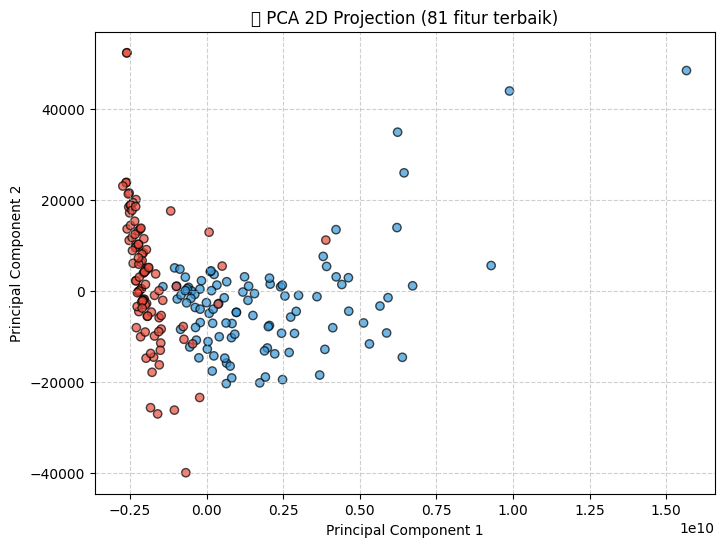

C:\Users\risqi\AppData\Local\Temp\ipykernel_13300\1216617396.py:44: UserWarning: Glyph 127752 (\N{RAINBOW}) missing from current font.
  plt.tight_layout()
c:\Users\risqi\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127752 (\N{RAINBOW}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


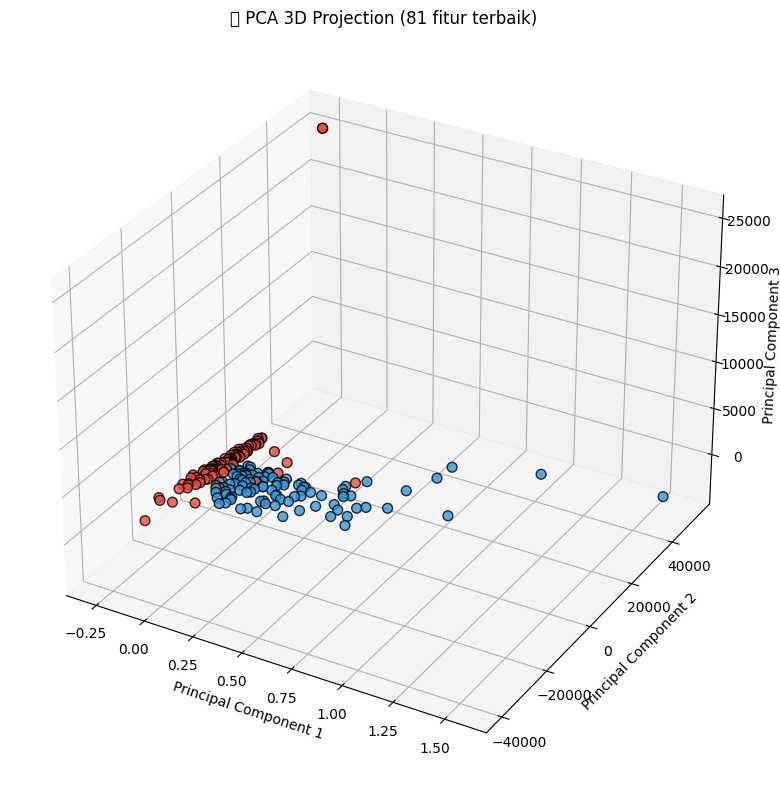

💡 Variansi dijelaskan oleh 2 komponen utama: 100.00%
 - PC1: 100.00%
 - PC2: 0.00%


In [82]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# === Lakukan PCA untuk reduksi dimensi ===
pca_2d = PCA(n_components=81)
X_pca_2d = pca_2d.fit_transform(X_top)

print(X_pca_2d.shape)

pca_3d = PCA(n_components=81)
X_pca_3d = pca_3d.fit_transform(X_top)

# === Warna label ===
colors = ['#3498db' if label == 0 else '#e74c3c' for label in y]

# === PCA 2D ===
plt.figure(figsize=(8, 6))
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=colors, alpha=0.7, edgecolors='k')
plt.title("🎨 PCA 2D Projection (81 fitur terbaik)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# === PCA 3D ===
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    X_pca_3d[:, 0],
    X_pca_3d[:, 1],
    X_pca_3d[:, 2],
    c=colors,
    alpha=0.8,
    s=50,
    edgecolors='k'
)

ax.set_title("🌈 PCA 3D Projection (81 fitur terbaik)")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
plt.tight_layout()
plt.show()

# === Tampilkan kontribusi masing-masing komponen utama ===
explained_variance = pca_2d.explained_variance_ratio_ * 100
print(f"💡 Variansi dijelaskan oleh 2 komponen utama: {explained_variance.sum():.2f}%")
print(f" - PC1: {explained_variance[0]:.2f}%")
print(f" - PC2: {explained_variance[1]:.2f}%")

